# CI project :Natural-inspired pattern Recognition for Classification Proplem



### Hyperparameter Optimization (HPO) of Machine Learning Models
####  Tradional Algorithms versus Natural inspired Algorithms

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split ,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix ,classification_report,accuracy_score
from sklearn import datasets
from sklearn.svm import SVC ,SVR
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor


## Load MNIST dataset
The MNIST database  is a large database of handwritten digits that is commonly used for training various image processing systems. The MNIST database has a training set of 60,000 examples, and a test set of 10,000 examples.

In [3]:
dataset = datasets.load_digits()
X = dataset.data
y = dataset.target

In [4]:
dataset

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

## Baseline Machine Learning Models: Classifiers with Default Hyperparameters

### Using 3-Fold Cross-Validation

In [5]:
#SVM
clf = SVC()
clf.fit(X,y)
scores = cross_val_score(clf, X ,y, cv=3 , scoring ='accuracy')
print("Accuracy:"+ str(scores.mean()))


Accuracy:0.9699499165275459


## Tradition Parameter tunning Methods  Algorithm 1: Grid Search
Search all the given hyper-parameter configurations

**Advantages:**
* Simple implementation.  

**Disadvantages:**  
* Time-consuming,
* Only efficient with categorical HPs.

In [6]:
# SVM optimized by GridSearchCv
from sklearn.model_selection import GridSearchCV
#Define hyperparameter Configuration space
svm_params = {
    'C':[1, 10, 100],
    'kernel' :['linear','poly','rbf','sigmoid']
}
clf = SVC(gamma='scale')
grid =GridSearchCV(clf,svm_params ,cv=3 ,scoring = 'accuracy')
grid.fit(X,y)
print(grid.best_params_)
print("Accuracy:"+str(grid.best_score_))
svc_accuracy_bygridsearch = grid.best_score_
svc_params_bygridsearch = grid.best_params_

{'C': 10, 'kernel': 'rbf'}
Accuracy:0.9738452977184195


##  Algorithm 2: Random Search
Randomly search hyper-parameter combinations in the search space

**Advantages:**
* More efficient than GS.
* Enable parallelization.

**Disadvantages:**  
* Not consider previous results.
* Not efficient with conditional HPs.

In [7]:
#SVM
from scipy import stats
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
rf_params = {
    'C': stats.uniform(0,50),
    "kernel":['linear','poly','rbf','sigmoid']
}
n_iter_search=20
clf = SVC(gamma='scale')
Random = RandomizedSearchCV(clf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='accuracy')
Random.fit(X, y)
print(Random.best_params_)
print("Accuracy:"+ str(Random.best_score_))
svc_accuracy_byrandomsearch = Random.best_score_
svc_params_byrandomsearch = Random.best_params_

{'C': 26.720445968831854, 'kernel': 'rbf'}
Accuracy:0.9738452977184195


## Run Hybrid BFO-PSO  optimization
Execute the Hybrid BFO-PSO  algorithm to optimize SVM hyperparameters (C and kernel). Track best accuracy over generations.


In [8]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Evaluate accuracy for a given C and kernel
def evaluate_continuous(C, kernel, X, y):
    clf = SVC(C=C, kernel=kernel, gamma='scale')
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    return scores.mean()

# Try multiple kernels and return best score + kernel for given C
def evaluate_with_kernels(C, X, y):
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    best_score = 0
    best_kernel = None
    for k in kernels:
        score = evaluate_continuous(C, k, X, y)
        if score > best_score:
            best_score = score
            best_kernel = k
    return best_score, best_kernel

# Hybrid BFO-PSO Algorithm
def hybrid_bfo_pso(X, y, n_gen=20, pop_size=10, C_bounds=(0.1, 1000)):
    w = 0.5      # inertia weight
    c1 = 1.5     # cognitive (pbest)
    c2 = 1.5     # social (gbest)

    # Initialize population (positions = C values), velocities
    position = np.random.uniform(C_bounds[0], C_bounds[1], pop_size)
    velocity = np.zeros(pop_size)

    # Initialize personal bests and global best
    pbest = position.copy()
    pbest_scores = np.zeros(pop_size)
    gbest = None
    gbest_score = 0

    fitness_over_gens = []

    # Initial evaluation
    for i in range(pop_size):
        score, _ = evaluate_with_kernels(position[i], X, y)
        pbest_scores[i] = score
        if score > gbest_score:
            gbest = position[i]
            gbest_score = score

    # Optimization loop
    for gen in range(n_gen):
        for i in range(pop_size):
            r1, r2 = np.random.rand(), np.random.rand()

            # Update velocity and position
            velocity[i] = (
                w * velocity[i]
                + c1 * r1 * (pbest[i] - position[i])
                + c2 * r2 * (gbest - position[i])
            )
            position[i] += velocity[i]
            position[i] = np.clip(position[i], C_bounds[0], C_bounds[1])

            # Evaluate new position
            score, _ = evaluate_with_kernels(position[i], X, y)
            if score > pbest_scores[i]:
                pbest[i] = position[i]
                pbest_scores[i] = score
                if score > gbest_score:
                    gbest = position[i]
                    gbest_score = score

        fitness_over_gens.append(gbest_score)
        print(f"Generation {gen+1} - Best Accuracy: {gbest_score:.4f}")

    # Final best params
    final_score, best_kernel = evaluate_with_kernels(gbest, X, y)
    best_params = {'C': gbest, 'kernel': best_kernel}
    return best_params, final_score, fitness_over_gens
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Evaluate accuracy for a given C and kernel
def evaluate_continuous(C, kernel, X, y):
    clf = SVC(C=C, kernel=kernel, gamma='scale')
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    return scores.mean()

# Try multiple kernels and return best score + kernel for given C
def evaluate_with_kernels(C, X, y):
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    best_score = 0
    best_kernel = None
    for k in kernels:
        score = evaluate_continuous(C, k, X, y)
        if score > best_score:
            best_score = score
            best_kernel = k
    return best_score, best_kernel

# Hybrid BFO-PSO Algorithm
def hybrid_bfo_pso(X, y, n_gen=20, pop_size=10, C_bounds=(0.1, 1000)):
    w = 0.5      # inertia weight
    c1 = 1.5     # cognitive (pbest)
    c2 = 1.5     # social (gbest)

    # Initialize population (positions = C values), velocities
    position = np.random.uniform(C_bounds[0], C_bounds[1], pop_size)
    velocity = np.zeros(pop_size)

    # Initialize personal bests and global best
    pbest = position.copy()
    pbest_scores = np.zeros(pop_size)
    gbest = None
    gbest_score = 0

    fitness_over_gens = []

    # Initial evaluation
    for i in range(pop_size):
        score, _ = evaluate_with_kernels(position[i], X, y)
        pbest_scores[i] = score
        if score > gbest_score:
            gbest = position[i]
            gbest_score = score

    # Optimization loop
    for gen in range(n_gen):
        for i in range(pop_size):
            r1, r2 = np.random.rand(), np.random.rand()

            # Update velocity and position
            velocity[i] = (
                w * velocity[i]
                + c1 * r1 * (pbest[i] - position[i])
                + c2 * r2 * (gbest - position[i])
            )
            position[i] += velocity[i]
            position[i] = np.clip(position[i], C_bounds[0], C_bounds[1])

            # Evaluate new position
            score, _ = evaluate_with_kernels(position[i], X, y)
            if score > pbest_scores[i]:
                pbest[i] = position[i]
                pbest_scores[i] = score
                if score > gbest_score:
                    gbest = position[i]
                    gbest_score = score

        fitness_over_gens.append(gbest_score)
        print(f"Generation {gen+1} - Best Accuracy: {gbest_score:.4f}")

    # Final best params
    final_score, best_kernel = evaluate_with_kernels(gbest, X, y)
    best_params = {'C': gbest, 'kernel': best_kernel}
    return best_params, final_score, fitness_over_gens


## Decode best Hybrid BFO-PSO result 
Extract the best SVM parameters from the Hybrid BFO-PSO result and print the best accuracy.


In [9]:
best_params_hybrid, accuracy_hybrid, fitness_curve_hybrid = hybrid_bfo_pso(X, y)

print("Best Params (Hybrid BFO-PSO):", best_params_hybrid)
print("Best Accuracy (Hybrid BFO-PSO):", accuracy_hybrid)



Generation 1 - Best Accuracy: 0.9738
Generation 2 - Best Accuracy: 0.9738
Generation 3 - Best Accuracy: 0.9738
Generation 4 - Best Accuracy: 0.9738
Generation 5 - Best Accuracy: 0.9738
Generation 6 - Best Accuracy: 0.9738
Generation 7 - Best Accuracy: 0.9738
Generation 8 - Best Accuracy: 0.9738
Generation 9 - Best Accuracy: 0.9738
Generation 10 - Best Accuracy: 0.9738
Generation 11 - Best Accuracy: 0.9738
Generation 12 - Best Accuracy: 0.9738
Generation 13 - Best Accuracy: 0.9738
Generation 14 - Best Accuracy: 0.9738
Generation 15 - Best Accuracy: 0.9738
Generation 16 - Best Accuracy: 0.9738
Generation 17 - Best Accuracy: 0.9738
Generation 18 - Best Accuracy: 0.9738
Generation 19 - Best Accuracy: 0.9738
Generation 20 - Best Accuracy: 0.9738
Best Params (Hybrid BFO-PSO): {'C': 398.8254813530312, 'kernel': 'rbf'}
Best Accuracy (Hybrid BFO-PSO): 0.9738452977184195


## Accuracy comparison plot
Compare the accuracies of GridSearchCV, RandomizedSearchCV, and Hybrid BFO-PSO using a bar chart.


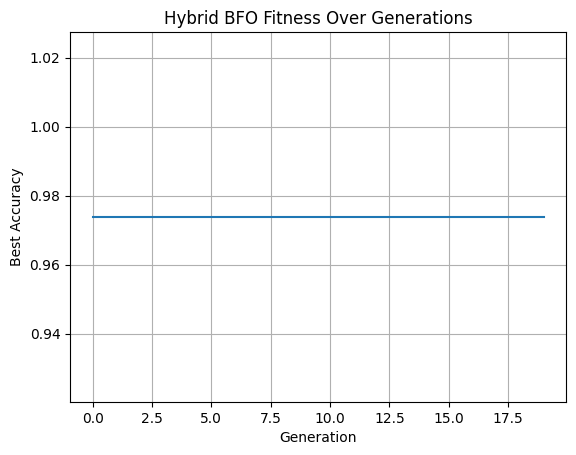

In [10]:
plt.plot(fitness_curve_hybrid)
plt.xlabel("Generation")
plt.ylabel("Best Accuracy")
plt.title("Hybrid BFO Fitness Over Generations")
plt.grid()
plt.show()


## Print best parameters and accuracies
 Display a side-by-side comparison of the best parameters and accuracies obtained from each optimization method.


=== Accuracy Comparison ===
GridSearchCV Accuracy:     0.9738 | Params: {'C': 10, 'kernel': 'rbf'}
RandomSearchCV Accuracy:   0.9738 | Params: {'C': 26.720445968831854, 'kernel': 'rbf'}
local search BFO Accuracy:       0.9738 | Params: {'C': 398.8254813530312, 'kernel': 'rbf'}


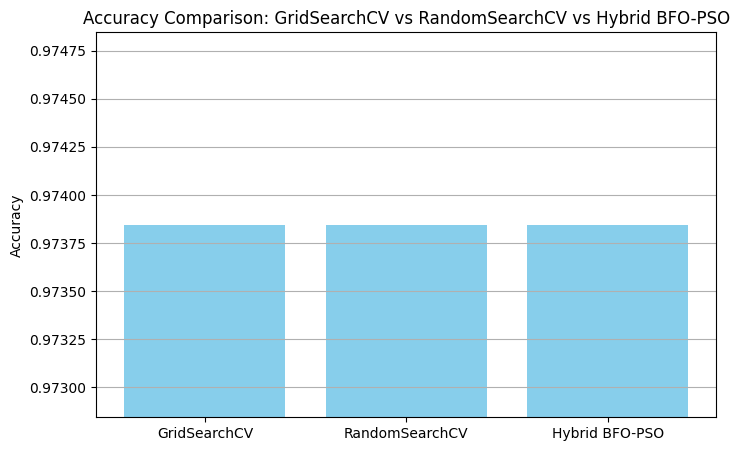

In [11]:
print("=== Accuracy Comparison ===")
print(f"GridSearchCV Accuracy:     {svc_accuracy_bygridsearch:.4f} | Params: {svc_params_bygridsearch}")
print(f"RandomSearchCV Accuracy:   {svc_accuracy_byrandomsearch:.4f} | Params: {svc_params_byrandomsearch}")
print(f"local search BFO Accuracy:       {accuracy_hybrid:.4f} | Params: {best_params_hybrid}")


import matplotlib.pyplot as plt

results = {
    'GridSearchCV': svc_accuracy_bygridsearch,
    'RandomSearchCV': svc_accuracy_byrandomsearch,
    'Hybrid BFO-PSO': accuracy_hybrid
}

labels = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracies, color='skyblue')
plt.ylabel('Accuracy')
plt.ylim(min(accuracies) - 0.001, max(accuracies) + 0.001)
plt.title('Accuracy Comparison: GridSearchCV vs RandomSearchCV vs Hybrid BFO-PSO')
plt.grid(axis='y')
plt.show()
